In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [9]:

data_path = "/content/drive/MyDrive/IMD_project/chest_xray"


sample_ratio = 1
batch_size = 96
num_epochs = 20

In [11]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
%run "/content/drive/MyDrive/IMD_project/Medical-Image-Diagnosis-using-Convolutional-Neural-Networks-main/utils.ipynb"
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

In [13]:
import torch
import torch.nn as nn
from torchvision import models

alexnet_path = "/content/drive/MyDrive/IMD_project/chest_xrayalexnet.pth"
resnet_path  = "/content/drive/MyDrive/IMD_project/chest_xrayresnet18.pth"

# number of classes
num_classes = 2    # NORMAL & PNEUMONIA


In [14]:
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.load_state_dict(torch.load(alexnet_path, map_location="cpu"))
alexnet.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load(resnet_path, map_location="cpu"))
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def get_predictions(model, dataloader):
    all_preds = []
    all_true = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    return np.array(all_true), np.array(all_preds)


====== AlexNet TEST ======
TEST: Accuracy: 0.9812 | Loss: 0.0595 | Recall: 0.9787 | Precision: 0.9752 | F-score: 0.9769



<Figure size 800x800 with 0 Axes>

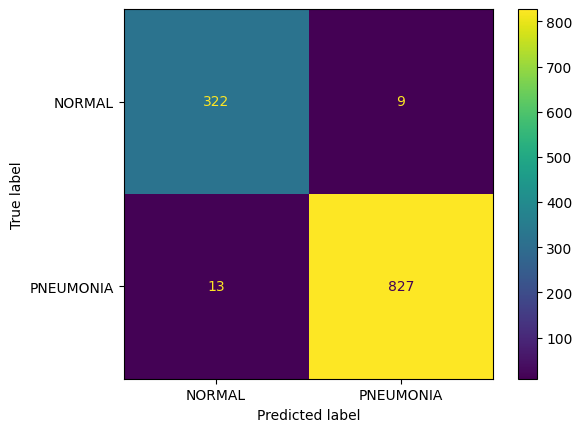

====== ResNet18 TEST ======
TEST: Accuracy: 0.9855 | Loss: 0.0406 | Recall: 0.9789 | Precision: 0.9852 | F-score: 0.9820



<Figure size 800x800 with 0 Axes>

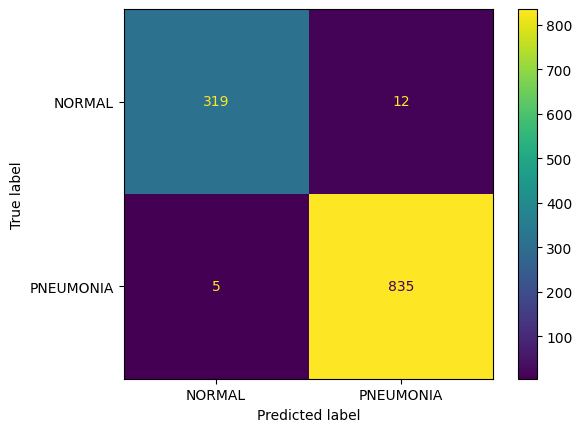

In [18]:
criterion = torch.nn.CrossEntropyLoss()

print("====== AlexNet TEST ======")
evaluate_model(alexnet, test_loader, test_indices, "TEST", criterion, data_path, "AlexNet")
alex_true, alex_pred = get_predictions(alexnet, test_loader)

print("====== ResNet18 TEST ======")
evaluate_model(resnet, test_loader, test_indices, "TEST", criterion, data_path, "ResNet18")
res_true, res_pred = get_predictions(resnet, test_loader)


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(true, pred):
    return {
        "Accuracy": accuracy_score(true, pred),
        "Precision": precision_score(true, pred, average='macro', zero_division=0),
        "Recall": recall_score(true, pred, average='macro', zero_division=0),
        "F1 Score": f1_score(true, pred, average='macro', zero_division=0)
    }

alex_metrics = compute_metrics(alex_true, alex_pred)
res_metrics  = compute_metrics(res_true, res_pred)


In [26]:
import pandas as pd

df = pd.DataFrame([
    ["AlexNet", alex_metrics["Accuracy"], alex_metrics["Precision"], alex_metrics["Recall"], alex_metrics["F1 Score"]],
    ["ResNet18", res_metrics["Accuracy"], res_metrics["Precision"], res_metrics["Recall"], res_metrics["F1 Score"]],
], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

print(df)


      Model  Accuracy  Precision    Recall  F1 Score
0   AlexNet  0.980359   0.973777  0.978072  0.975893
1  ResNet18  0.986336   0.984902  0.981323  0.983091


In [36]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# ==============================
# 1. PATHS
# ==============================
alexnet_path = "/content/drive/MyDrive/IMD_project/chest_xrayalexnet.pth"
resnet_path  = "/content/drive/MyDrive/IMD_project/chest_xrayresnet18.pth"

test_image_path = "/content/drive/MyDrive/IMD_project/x-ray.jpeg"  # <-- change this

# ==============================
# 2. CLASS NAMES (VERY IMPORTANT)
# ==============================
class_names = ["NORMAL", "PNEUMONIA"]  # Change if needed


# ==============================
# 3. TRANSFORMS
# ==============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# ==============================
# 4. LOAD ALEXNET MODEL
# ==============================
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(4096, len(class_names))
alexnet.load_state_dict(torch.load(alexnet_path, map_location="cpu"))
alexnet.eval()


# ==============================
# 5. LOAD RESNET18 MODEL
# ==============================
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet.load_state_dict(torch.load(resnet_path, map_location="cpu"))
resnet.eval()


# ==============================
# 6. PREDICT FUNCTION
# ==============================
def predict(model, image_path):
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(tensor)
        _, pred = torch.max(output, 1)
        return class_names[pred.item()]


# ==============================
# 7. RUN BOTH MODELS
# ==============================
alexnet_pred = predict(alexnet, test_image_path)
resnet_pred  = predict(resnet, test_image_path)

print("====================================")
print("         MODEL COMPARISON")
print("====================================")
print(f"AlexNet Prediction  : {alexnet_pred}")
print(f"ResNet18 Prediction : {resnet_pred}")
print("====================================")


         MODEL COMPARISON
AlexNet Prediction  : NORMAL
ResNet18 Prediction : NORMAL
